In [12]:
import pandas as pd

df = pd.read_csv("all_sets_df.csv")

In [2]:
METADATA_COLS = ["type", "row", "col", "well", "set", "type.f", "slide"]

# Get feature columns (all columns except metadata)
FEATURE_COLS = [col for col in df.columns if col not in METADATA_COLS]

TREATMENTS = set(["gene"])
CONTROLS = set(df["type"]) - TREATMENTS
print(f"Unique types: {set(df['type'])}")  # Unique types
print(f"Treatments: {TREATMENTS}")
print(f"Controls: {CONTROLS}")

Unique types: {'rfnotDL', 'gene', 'fit1', 'bscl2', 'rf'}
Treatments: {'gene'}
Controls: {'bscl2', 'rfnotDL', 'rf', 'fit1'}


In [ ]:
import plotly.graph_objects as go


def plot_3d_scatter(df, x_col, y_col, z_col, type_col="type", title="3D Scatter Plot"):
    """Create a 3D scatter plot colored by type."""
    fig = go.Figure()

    # Plot points for each type with different colors
    for type_name in df[type_col].unique():
        mask = df[type_col] == type_name
        df_filtered = df[mask]

        fig.add_trace(
            go.Scatter3d(
                x=df_filtered[x_col],
                y=df_filtered[y_col],
                z=df_filtered[z_col],
                mode="markers",
                name=type_name,
                marker=dict(size=6, opacity=0.7),
            )
        )

    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=x_col,
            yaxis_title=y_col,
            zaxis_title=z_col,
        ),
        width=1200,
        height=1200,
        showlegend=True,
    )

    return fig


def save_plot(fig, filename):
    """Save the plot as HTML."""
    fig.write_html(filename)
    return fig

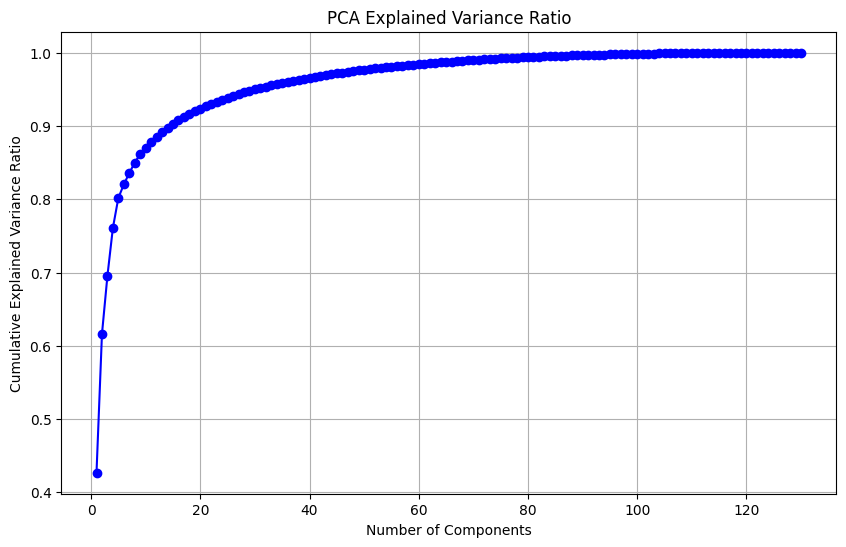

In [17]:
# Perform PCA on the feature columns only
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np


def preprocess_data(df, feature_cols):
    """Standardize the feature data."""
    X = df[feature_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X, X_scaled


def perform_pca(X_scaled):
    """Perform PCA and return transformed data and PCA object."""
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca


def plot_explained_variance(pca):
    """Plot the cumulative explained variance ratio."""
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, "bo-"
    )
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.title("PCA Explained Variance Ratio")
    plt.grid(True)
    plt.show()

    return cumulative_variance_ratio


def create_dimension_reduction_df(
    X_transformed, n_components, prefix, df_original, type_col="type"
):
    """Create a DataFrame with dimensionality reduction results."""
    columns = [f"{prefix}{i + 1}" for i in range(n_components)]
    result_df = pd.DataFrame(X_transformed[:, :n_components], columns=columns)
    result_df[type_col] = df_original[type_col]
    return result_df


# Main execution
X, X_scaled = preprocess_data(df, FEATURE_COLS)
X_pca, pca = perform_pca(X_scaled)
plot_explained_variance(pca)

# Create PCA DataFrame and plot
pca_df = create_dimension_reduction_df(X_pca, 3, "PC", df)
pca_fig = plot_3d_scatter(
    pca_df, "PC1", "PC2", "PC3", title="PCA: First Three Principal Components"
)
save_plot(pca_fig, "pca_3d_plot.html")


In [18]:
# Apply UMAP for dimensionality reduction

from umap import UMAP


def perform_umap(data, n_components=3, random_state=42, n_neighbors=200, min_dist=0.8):
    """Perform UMAP dimensionality reduction on the input data."""
    umap_model = UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    umap_result = umap_model.fit_transform(data)
    return umap_result, umap_model


def create_umap_df(umap_result, n_components, prefix="UMAP", original_df=None):
    """Create a DataFrame from UMAP results with optional metadata from original DataFrame."""
    columns = [f"{prefix}{i + 1}" for i in range(n_components)]
    umap_df = pd.DataFrame(umap_result, columns=columns)

    if original_df is not None and "type" in original_df.columns:
        umap_df["type"] = original_df["type"]

    return umap_df


# Perform UMAP and create DataFrame
X_umap, umap_model = perform_umap(X_scaled)
umap_df = create_umap_df(X_umap, 3, original_df=df)

# Plot UMAP results
umap_fig = plot_3d_scatter(
    umap_df, "UMAP1", "UMAP2", "UMAP3", title="3D UMAP Projection"
)

save_plot(umap_fig, "umap_3d_plot.html")


/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

